In [1]:
import numpy as np
from matplotlib import pyplot as plt

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [2]:
import equinox as eqx
from nn import Module, Network

In [3]:
# Hyperparameters

BATCH_SIZE = 1
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

In [4]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [5]:
layer1 = Module(
    eqx.nn.Linear(
        in_features=28*28,
        out_features=1024,
        key=jr.PRNGKey(SEED)
    )
)
layer2 = Module(
    eqx.nn.Linear(
        in_features=1024,
        out_features=10,
        key=jr.PRNGKey(SEED)
    ),
    jax.nn.softmax
)

model = Network(
    [layer1, layer2],
    optax.adam(LEARNING_RATE)
)

print(model)

Network(
goodness: 0.0,
trainable layers: [0, 1],
optimizer: GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f1c9c9862a0>, update=<function chain.<locals>.update_fn at 0x7f1c9c984e00>),
Layer 0: Module(
  _layer=Linear(
    weight=f32[1024,784],
    bias=f32[1024],
    in_features=784,
    out_features=1024,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=1.0
),
Layer 1: Module(
  _layer=Linear(
    weight=f32[10,1024],
    bias=f32[10],
    in_features=1024,
    out_features=10,
    use_bias=True
  ),
  _activation=<function softmax>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=1.0
),
)


In [6]:
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # BATCH_SIZEx1x28x28
print(dummy_y.shape)  # BATCH_SIZE
print(dummy_y)

(1, 1, 28, 28)
(1,)
[5]


In [7]:
def overlay_y_on_x(x: Array, y: Array):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = jnp.ravel(x)
    x_ = x_.at[:10].set(jnp.zeros((10,)))
    x_ = x_.at[y.item()].set(1)

    return x_.reshape(x.shape)


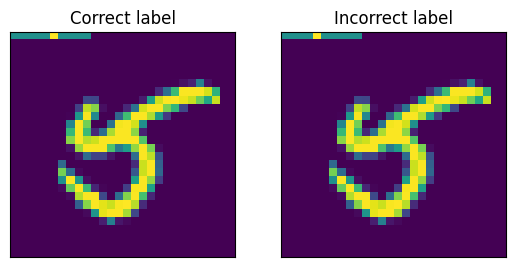

In [8]:
dummy_x_p = overlay_y_on_x(np.squeeze(dummy_x), dummy_y)
dummy_x_n = overlay_y_on_x(np.squeeze(dummy_x), 9 - dummy_y) # arbitrary but incorrect label

ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(dummy_x_p)
ax.set_title("Correct label")
ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(dummy_x_n)
ax.set_title("Incorrect label")
plt.show()

In [9]:
# train the first layer
for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), 9 - y)

    p_p, _, _ = model.train_layer(0, np.ravel(x_p), True)
    p_n, _, _ = model.train_layer(0, np.ravel(x_n), False)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: p(positive)={p_p:.4f}")
        print(f"Step {i}: p(negative)={p_n:.4f}")

Step 0: p(positive)=0.3296
Step 0: p(negative)=0.3842
Step 30: p(positive)=0.3278
Step 30: p(negative)=0.3495
Step 60: p(positive)=0.3192
Step 60: p(negative)=0.3338
Step 90: p(positive)=0.3147
Step 90: p(negative)=0.3357
Step 120: p(positive)=0.3167
Step 120: p(negative)=0.3286
Step 150: p(positive)=0.3124
Step 150: p(negative)=0.3237
Step 180: p(positive)=0.3059
Step 180: p(negative)=0.3185
Step 210: p(positive)=0.3017
Step 210: p(negative)=0.3142
Step 240: p(positive)=0.3106
Step 240: p(negative)=0.3207
Step 270: p(positive)=0.3007
Step 270: p(negative)=0.3091


In [10]:
# train the second layer
for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), 9 - y)

    x_p = model.layers[0].forward(np.ravel(x_p))
    x_n = model.layers[0].forward(np.ravel(x_n))

    p_p, _, _ = model.train_layer(1, np.ravel(x_p), True)
    p_n, _, _ = model.train_layer(1, np.ravel(x_n), False)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: p(positive)={p_p:.4f}")
        print(f"Step {i}: p(negative)={p_n:.4f}")

Step 0: p(positive)=0.2710
Step 0: p(negative)=0.2710
Step 30: p(positive)=0.2709
Step 30: p(negative)=0.2709
Step 60: p(positive)=0.2709
Step 60: p(negative)=0.2709
Step 90: p(positive)=0.2710
Step 90: p(negative)=0.2710
Step 120: p(positive)=0.2709
Step 120: p(negative)=0.2709
Step 150: p(positive)=0.2711
Step 150: p(negative)=0.2711
Step 180: p(positive)=0.2710
Step 180: p(negative)=0.2710
Step 210: p(positive)=0.2710
Step 210: p(negative)=0.2710
Step 240: p(positive)=0.2710
Step 240: p(negative)=0.2710
Step 270: p(positive)=0.2710
Step 270: p(negative)=0.2710
